In [ ]:
#import zipfile

# Replace 'images.zip' with the actual name of your ZIP file
#with zipfile.ZipFile('/content/drive/MyDrive/Desertation/archive.zip', 'r') as zip_ref:
    #zip_ref.extractall('/content/drive/MyDrive/Desertation/CTSCAN')

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd

In [ ]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '/Users/dhaneshkumarkapadia/Desktop/CTSCAN'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/Covid (640).png,0,COVID
1,COVID/Covid (210).png,0,COVID
2,COVID/Covid (705).png,0,COVID
3,COVID/Covid (355).png,0,COVID
4,COVID/Covid (586).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1052).png,1,non-COVID
2477,non-COVID/Non-Covid (51).png,1,non-COVID
2478,non-COVID/Non-Covid (1117).png,1,non-COVID
2479,non-COVID/Non-Covid (671).png,1,non-COVID


,File,ID,Disease Type
0,COVID/Covid (705).png,0,COVID
1,COVID/Covid (432).png,0,COVID
2,COVID/Covid (257).png,0,COVID
3,non-COVID/Non-Covid (412).png,1,non-COVID
4,COVID/Covid (783).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (103).png,1,non-COVID
2477,non-COVID/Non-Covid (605).png,1,non-COVID
2478,non-COVID/Non-Covid (534).png,1,non-COVID
2479,non-COVID/Non-Covid (374).png,1,non-COVID


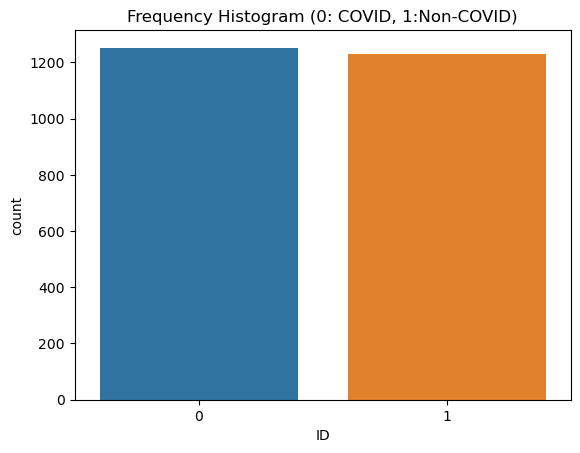

In [ ]:
import seaborn as sns
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: COVID, 1:Non-COVID)")
train

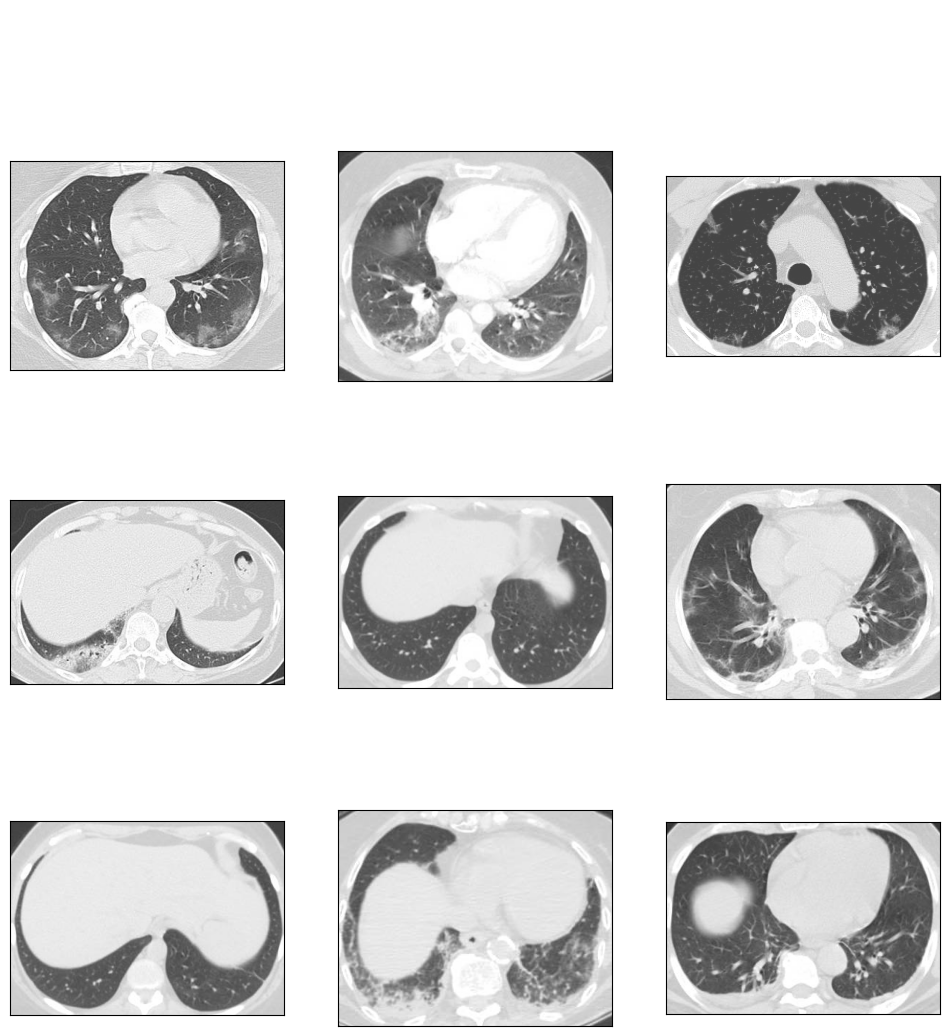

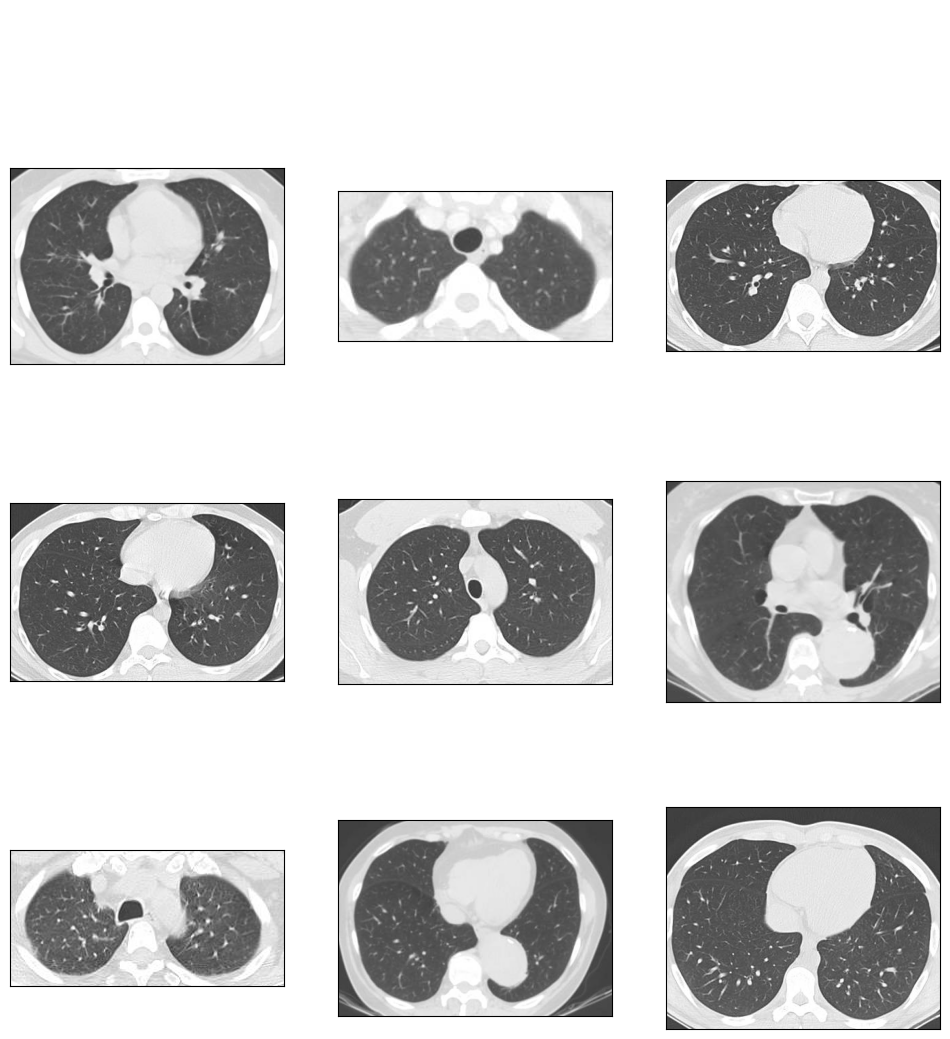

In [ ]:
import matplotlib.pyplot as plt
import cv2
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values

    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)

In [ ]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
from keras.utils.np_utils import to_categorical

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

2023-07-19 12:56:02.857708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Shape: (2481, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Define the input image size and number of channels
IMAGE_SIZE = 224
channels = 3

def build_desnet169(IMAGE_SIZE, channels):
    densenet169 = DenseNet169(weights='imagenet', include_top=False)

    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(inputs)
    x = densenet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = LegacyAdam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

# Build the DenseNet-169 model
model = build_desnet169(IMAGE_SIZE, channels)

# Define the callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model with augmented images
datagen.fit(X_train)  # Assuming X_train is defined and contains the training images

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=75,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)  # Assuming X_val and Y_val are defined and contain the validation data
)

# Save the model architecture as a plot
plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)


2023-07-19 12:56:26.625751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-19 12:56:26.626029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                106560

2023-07-19 12:56:34.565674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-19 12:56:40.310302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7379

2023-07-19 12:57:38.789226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.90901, saving model to model.h5
62/62 [==============================] - 74s 801ms/step - loss: 0.5605 - accuracy: 0.7379 - val_loss: 0.9090 - val_accuracy: 0.5453 - lr: 0.0030
Epoch 2/75
62/62 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8347
Epoch 2: val_loss did not improve from 0.90901
62/62 [==============================] - 39s 615ms/step - loss: 0.3950 - accuracy: 0.8347 - val_loss: 0.9640 - val_accuracy: 0.6237 - lr: 0.0030
Epoch 3/75
62/62 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8604
Epoch 3: val_loss improved from 0.90901 to 0.66359, saving model to model.h5
62/62 [==============================] - 40s 642ms/step - loss: 0.3401 - accuracy: 0.8604 - val_loss: 0.6636 - val_accuracy: 0.7123 - lr: 0.0030
Epoch 4/75
62/62 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8790
Epoch 4: val_loss did not improve from 0.66359
62/62 [==============================]

62/62 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9834
Epoch 28: val_loss did not improve from 0.04410
62/62 [==============================] - 38s 602ms/step - loss: 0.0518 - accuracy: 0.9834 - val_loss: 0.0845 - val_accuracy: 0.9638 - lr: 0.0015
Epoch 29/75
62/62 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9839
Epoch 29: val_loss did not improve from 0.04410
62/62 [==============================] - 38s 604ms/step - loss: 0.0534 - accuracy: 0.9839 - val_loss: 0.0553 - val_accuracy: 0.9819 - lr: 0.0015
Epoch 30/75
62/62 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9919
Epoch 30: val_loss did not improve from 0.04410
62/62 [==============================] - 38s 609ms/step - loss: 0.0362 - accuracy: 0.9919 - val_loss: 0.0452 - val_accuracy: 0.9819 - lr: 0.0015
Epoch 31/75
62/62 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9879
Epoch 31: val_loss did not improve from 0.04410
62/62

62/62 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9929
Epoch 55: val_loss did not improve from 0.01766
62/62 [==============================] - 38s 606ms/step - loss: 0.0189 - accuracy: 0.9929 - val_loss: 0.0631 - val_accuracy: 0.9779 - lr: 5.0421e-04
Epoch 56/75
62/62 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9950
Epoch 56: val_loss did not improve from 0.01766
62/62 [==============================] - 38s 610ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0572 - val_accuracy: 0.9779 - lr: 5.0421e-04
Epoch 57/75
62/62 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9965
Epoch 57: val_loss did not improve from 0.01766
62/62 [==============================] - 38s 609ms/step - loss: 0.0140 - accuracy: 0.9965 - val_loss: 0.0401 - val_accuracy: 0.9799 - lr: 5.0421e-04
Epoch 58/75
62/62 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9960
Epoch 58: ReduceLROnPlateau reducing lear

In [ ]:
# Save the trained model
model.save('ct_scan_classification_model.h5')


16/16 [==============================] - 3s 140ms/step
True Positive: 253
False Negative: 2
True Negative: 241
False Positive: 1
True Positive Rate: 0.9921568627450981
True Negative Rate: 0.9958677685950413

Total Evaluation Time: 3.35s
Frame Rate: 148.15 samples/s
16/16 [==============================] - 2s 141ms/step - loss: 0.0179 - accuracy: 0.9940

Final Loss: 0.017945729196071625, Final Accuracy: 0.9939637780189514


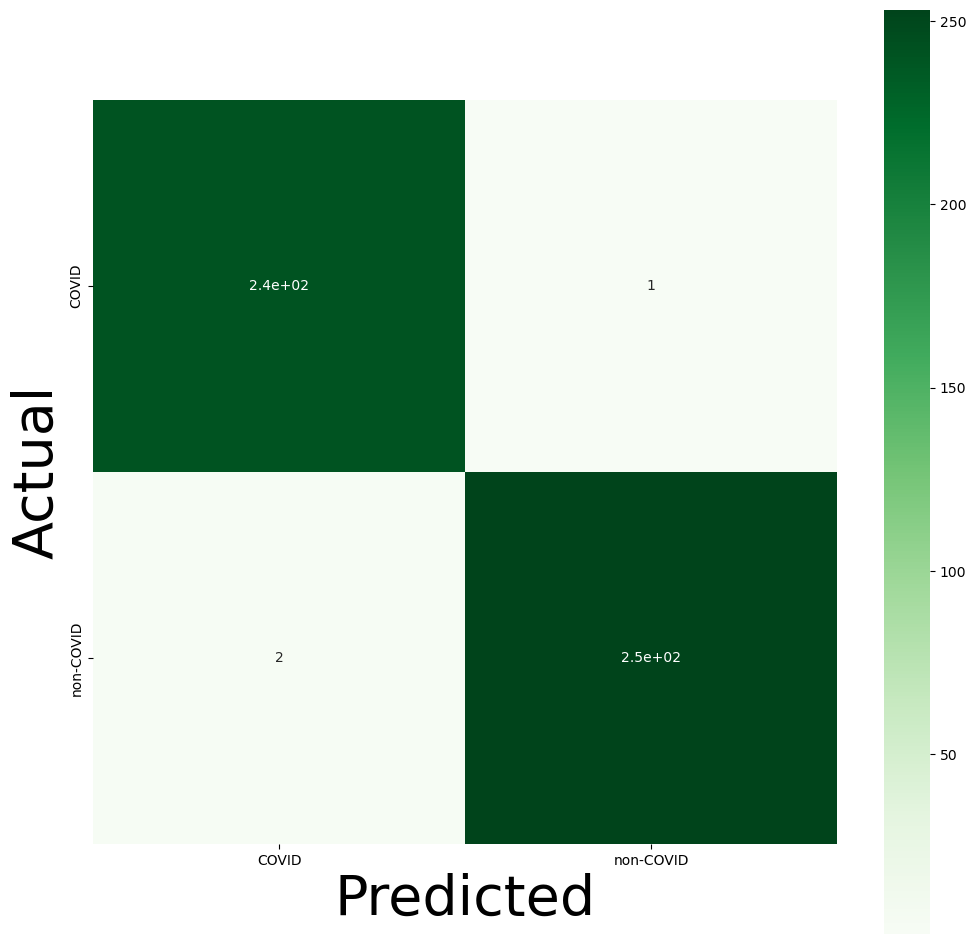

In [ ]:
import time
from sklearn.metrics import confusion_matrix

# Rest of your code...

start_time = time.time()

Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

TP = cm[1][1]
print(f"True Positive: {TP}")

FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

end_time = time.time()
total_time = end_time - start_time
frame_rate = len(X_val) / total_time

print(f"Total Evaluation Time: {total_time:.2f}s")
print(f"Frame Rate: {frame_rate:.2f} samples/s")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")
